In [89]:
# Настройка отображения в Jupyter Notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Основные пакеты для работы с данными и вычислений
import numpy as np
import pandas as pd
from scipy.stats import t
from collections import Counter

# Пакеты для визуализации
import matplotlib as mpl
import seaborn as sns

# Машинное обучение: предобработка, модели, оценка качества
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Настройки для воспроизводимости результатов
my_seed = 17  
plt = mpl.pyplot

# Стили графиков для лучшей читаемости
plt.style.use('seaborn-v0_8-whitegrid')  
sns.set_palette("Set2")

print("Все необходимые пакеты успешно загружены")

C:\Users\daria\AppData\Local\Temp\ipykernel_8396\4247043395.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


Все необходимые пакеты успешно загружены


In [90]:
def plot_coeffs_traces(X, y, class_number, penalty_name, C_opt, col_names, C_min_pow=-4, C_max_pow=3):
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    
    # Цветовая схема для разных признаков
    colors = sns.color_palette("Spectral", len(col_names))
    
    # Сбор коэффициентов для разных значений C
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, C=10.0**c, solver='liblinear',  # Исправлено: 10.0**c вместо 10**c
                               multi_class='ovr', random_state=my_seed, max_iter=1000)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10.0**c)
    
    weights = np.array(weights)
    
    # Траектории изменения коэффициентов
    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column], label=col_names[column], color=color)
    
    # Оптимальное значение C
    plt.axvline(x=C_opt[class_number], color='magenta', linestyle='--', linewidth=2)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10.0**(C_min_pow), 10.0**C_max_pow])  
    plt.ylabel('Весовой коэффициент')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1.0), ncol=1, fancybox=True)
    plt.title(f'Сжатие коэффициентов ({penalty_name}) - Класс {class_number}')
    plt.show()

print("Функция для анализа сжатия коэффициентов готова")

Функция для анализа сжатия коэффициентов готова


In [91]:
# Данные кредитных карт клиентов
url = "https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv"
try:
    DF_all = pd.read_csv(url)
    print(f"Данные успешно загружены. Всего: {DF_all.shape[0]} строк, {DF_all.shape[1]} столбцов")
except Exception as e:
    print(f"Ошибка загрузки: {e}")

Данные успешно загружены. Всего: 30000 строк, 24 столбцов


In [92]:
columns_to_exclude = ['Y', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

explaining_vars = [col for col in DF_all.columns if col not in columns_to_exclude]

print(f"Исключаемые столбцы: {columns_to_exclude}")
print(f"Оставляемые для анализа: {explaining_vars}")
print(f"Количество признаков для модели: {len(explaining_vars)}")

# Итоговый датасет с нужными переменными
DF_processed = DF_all[explaining_vars + ['Y']].copy()
print(f"Итоговый размер данных: {DF_processed.shape}")

Исключаемые столбцы: ['Y', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Оставляемые для анализа: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']
Количество признаков для модели: 11
Итоговый размер данных: (30000, 12)


In [93]:
# Наблюдения для моделирования (85%)
DF = DF_processed.sample(frac=0.85, random_state=my_seed)
# Отложенные наблюдения (15%)
DF_predict = DF_processed.drop(DF.index)

print("Разделение данных завершено:")
print(f"Обучающая выборка: {DF.shape}")
print(f"Тестовая выборка: {DF_predict.shape}")

Разделение данных завершено:
Обучающая выборка: (25500, 12)
Тестовая выборка: (4500, 12)


In [94]:
# Распределение классов
print("Распределение классов в обучающей выборке:")
print(DF['Y'].value_counts(normalize=True).round(3))
print("Распределение классов в тестовой выборке:")
print(DF_predict['Y'].value_counts(normalize=True).round(3))

Распределение классов в обучающей выборке:
Y
0    0.779
1    0.221
Name: proportion, dtype: float64
Распределение классов в тестовой выборке:
Y
0    0.778
1    0.222
Name: proportion, dtype: float64


In [95]:
# Проверка пропусков
print("Проверка пропусков в данных:")
print(DF.isna().sum())

Проверка пропусков в данных:
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
Y            0
dtype: int64


In [96]:
# Основные статистики
print("Основные статистики целевой переменной:")
print(DF['Y'].describe())

Основные статистики целевой переменной:
count    25500.000000
mean         0.221137
std          0.415021
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Y, dtype: float64


In [97]:
print("Основные статистики объясняющих переменных:")
print(DF[explaining_vars].describe().round(3))

Основные статистики объясняющих переменных:
         LIMIT_BAL        SEX  EDUCATION   MARRIAGE        AGE      PAY_0  \
count    25500.000  25500.000  25500.000  25500.000  25500.000  25500.000   
mean    168409.791      1.603      1.852      1.551     35.501     -0.018   
std     130337.089      0.489      0.791      0.521      9.230      1.126   
min      10000.000      1.000      0.000      0.000     21.000     -2.000   
25%      50000.000      1.000      1.000      1.000     28.000     -1.000   
50%     140000.000      2.000      2.000      2.000     34.000      0.000   
75%     240000.000      2.000      2.000      2.000     41.000      0.000   
max    1000000.000      2.000      6.000      3.000     79.000      8.000   

           PAY_2      PAY_3   BILL_AMT1   BILL_AMT2    BILL_AMT3  
count  25500.000  25500.000   25500.000   25500.000    25500.000  
mean      -0.138     -0.165   51278.389   49240.653    47093.672  
std        1.198      1.199   74022.431   71578.916    69773.

<Figure size 1200x1000 with 0 Axes>

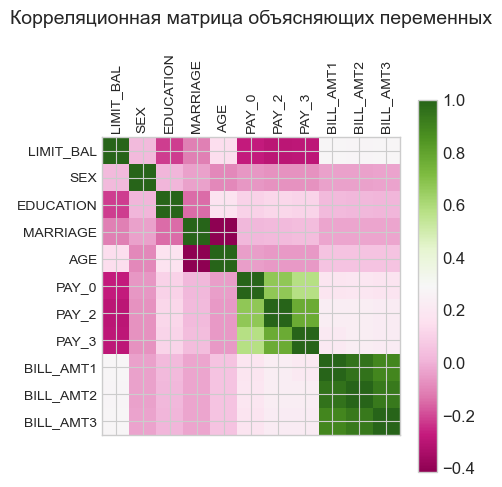

In [98]:
# Расчет корреляционной матрицы
corr_mat = DF[explaining_vars].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 10))
plt.matshow(corr_mat, cmap='PiYG')
tics_coords = np.arange(0, len(explaining_vars))
plt.xticks(tics_coords, explaining_vars, fontsize=10, rotation=90)
plt.yticks(tics_coords, explaining_vars, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Корреляционная матрица объясняющих переменных', fontsize=14, pad=20)
plt.show()

In [99]:
# Анализ значимых корреляций
df_corr = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
df_corr = df_corr.stack().reset_index()
df_corr.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']

# P-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df_corr.Корреляция.values ** 2))
df_corr['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))

# Самые сильные корреляции
significant_corrs = df_corr.loc[df_corr['P_значение'] < 0.05].sort_values('Корреляция')
print("Самые сильные положительные корреляции:")
print(significant_corrs.nlargest(5, 'Корреляция')[['Показатель_1', 'Показатель_2', 'Корреляция']])
print("Самые сильные отрицательные корреляции:")
print(significant_corrs.nsmallest(5, 'Корреляция')[['Показатель_1', 'Показатель_2', 'Корреляция']])

Самые сильные положительные корреляции:
   Показатель_1 Показатель_2  Корреляция
52    BILL_AMT1    BILL_AMT2    0.950832
54    BILL_AMT2    BILL_AMT3    0.928650
53    BILL_AMT1    BILL_AMT3    0.891680
45        PAY_2        PAY_3    0.768484
40        PAY_0        PAY_2    0.673593
Самые сильные отрицательные корреляции:
   Показатель_1 Показатель_2  Корреляция
27     MARRIAGE          AGE   -0.415197
5     LIMIT_BAL        PAY_2   -0.296231
6     LIMIT_BAL        PAY_3   -0.288631
4     LIMIT_BAL        PAY_0   -0.272081
1     LIMIT_BAL    EDUCATION   -0.220484


In [100]:
# Стандартизация объясняющих переменных
sc = StandardScaler()
X_train_std = sc.fit_transform(DF[explaining_vars].values)
Y_train = DF.Y.values

# Проверка стандартизации
print("Проверка стандартизации (первые 5 переменных):")
for i_col in range(min(5, X_train_std.shape[1])):
    print(f'Столбец {i_col}: среднее = {np.mean(X_train_std[:, i_col]):.6f}, '
          f'станд. отклонение = {np.std(X_train_std[:, i_col]):.6f}')

Проверка стандартизации (первые 5 переменных):
Столбец 0: среднее = -0.000000, станд. отклонение = 1.000000
Столбец 1: среднее = 0.000000, станд. отклонение = 1.000000
Столбец 2: среднее = 0.000000, станд. отклонение = 1.000000
Столбец 3: среднее = 0.000000, станд. отклонение = 1.000000
Столбец 4: среднее = 0.000000, станд. отклонение = 1.000000


In [101]:
# Метод главных компонент
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

# Доли объясненной дисперсии
frac_var_expl = pca.explained_variance_ratio_
print("Доли объясненной дисперсии по компонентам:")
for i, frac in enumerate(frac_var_expl[:10], 1):
    print(f'Компонента {i}: {frac:.3f}')

# Выбор числа компонент (объясняют 80% дисперсии)
n_components = np.where(np.cumsum(frac_var_expl) >= 0.8)[0][0] + 1
print(f"Количество компонент для 80% дисперсии: {n_components}")

Доли объясненной дисперсии по компонентам:
Компонента 1: 0.301
Компонента 2: 0.214
Компонента 3: 0.137
Компонента 4: 0.093
Компонента 5: 0.083
Компонента 6: 0.052
Компонента 7: 0.048
Компонента 8: 0.040
Компонента 9: 0.020
Компонента 10: 0.010
Количество компонент для 80% дисперсии: 5


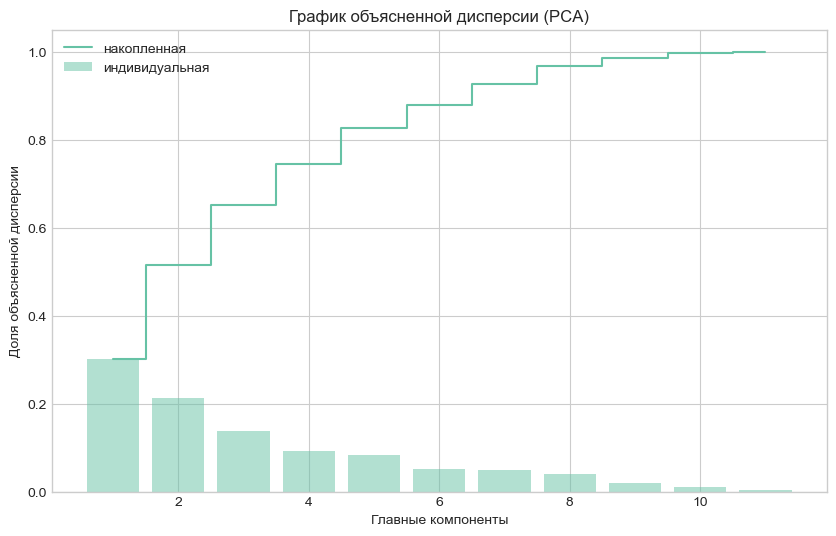

In [102]:
# График объясненной дисперсии
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(frac_var_expl)+1), frac_var_expl, alpha=0.5, align='center', 
        label='индивидуальная')
plt.step(range(1, len(frac_var_expl)+1), np.cumsum(frac_var_expl), where='mid', 
         label='накопленная')
plt.ylabel('Доля объясненной дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.title('График объясненной дисперсии (PCA)')
plt.show()

In [103]:
# Регрессия на главных компонентах (PCR)
pca_final = PCA(n_components=n_components)
X_train_pca_final = pca_final.fit_transform(X_train_std)

# Логистическая регрессия на главных компонентах
logit_pcr = LogisticRegression(random_state=my_seed, max_iter=1000)
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)

# Оценка точности PCR с перекрестной проверкой
acc_pcr = cross_val_score(logit_pcr, X_train_pca_final, Y_train, cv=kf_10, scoring='accuracy').mean()

print("Регрессия на главных компонентах (PCR):")
print(f"Перекрестная проверка по 10 блокам: Acc = {acc_pcr:.3f}")

# Обучение финальной PCR модели
logit_pcr.fit(X_train_pca_final, Y_train)
print("PCR модель успешно обучена")

Регрессия на главных компонентах (PCR):
Перекрестная проверка по 10 блокам: Acc = 0.804
PCR модель успешно обучена


In [104]:
# Подбор оптимального гиперпараметра C для ридж-регрессии
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed, penalty='l2', 
                               solver='liblinear', max_iter=1000)
ridge_cv.fit(X_train_std, Y_train)

print("Оптимальные значения C для ридж-регрессии:")
print(ridge_cv.C_)

Оптимальные значения C для ридж-регрессии:
[0.35938137]


In [105]:
# Оценка точности ридж-регрессии
acc_ridge = ridge_cv.score(X_train_std, Y_train)
print(f"Точность ридж-регрессии: Acc = {acc_ridge:.3f}")

Точность ридж-регрессии: Acc = 0.810


Графики сжатия коэффициентов (ридж-регрессия):
Класс 0:


c:\Users\daria\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\daria\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\daria\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\daria\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_clas

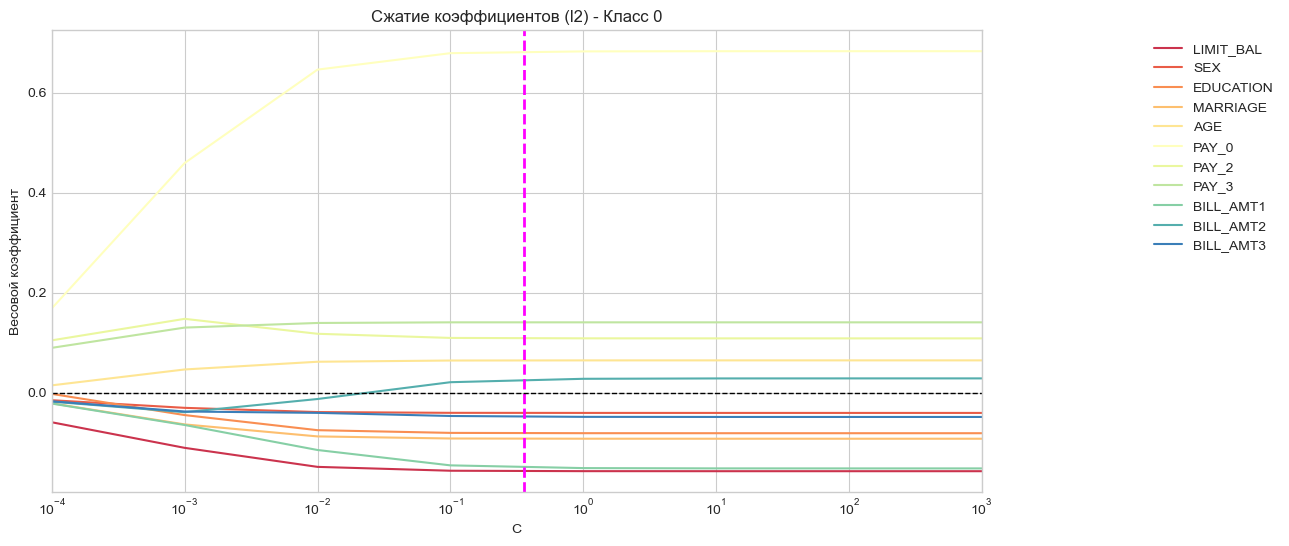

In [106]:
# Графики сжатия коэффициентов для каждого класса
print("Графики сжатия коэффициентов (ридж-регрессия):")
for class_num in range(len(ridge_cv.C_)):
    print(f"Класс {class_num}:")
    plot_coeffs_traces(X_train_std, Y_train, class_num, 'l2', ridge_cv.C_, explaining_vars)

In [107]:
# Сводка по точности моделей
models_summary = pd.DataFrame({
    'Модель': ['PCR', 'Ridge'],
    'Acc': [acc_pcr, acc_ridge]
})

print("Сравнение точности моделей:")
print(models_summary)

Сравнение точности моделей:
  Модель       Acc
0    PCR  0.803647
1  Ridge  0.809725


In [108]:
# Выбор лучшей модели
best_model_name = models_summary.loc[models_summary['Acc'].idxmax(), 'Модель']
best_model = ridge_cv if best_model_name == 'Ridge' else logit_pcr

print(f"Лучшая модель: {best_model_name} с точностью {models_summary['Acc'].max():.3f}")

Лучшая модель: Ridge с точностью 0.810


In [109]:
# Подготовка отложенных данных
X_test_std = sc.transform(DF_predict[explaining_vars].values)
Y_test = DF_predict.Y.values

# Прогноз лучшей моделью
if best_model_name == 'PCR':
    X_test_pca = pca_final.transform(X_test_std)
    Y_pred = best_model.predict(X_test_pca)
else:
    Y_pred = best_model.predict(X_test_std)

# Оценка точности прогноза
accuracy_test = accuracy_score(Y_test, Y_pred)
classification_rep = classification_report(Y_test, Y_pred)

print("Прогноз на отложенных наблюдениях:")
print(f"Точность на тестовой выборке: {accuracy_test:.3f}")
print("Отчет по классификации:")
print(classification_rep)

Прогноз на отложенных наблюдениях:
Точность на тестовой выборке: 0.809
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3503
           1       0.71      0.24      0.36       997

    accuracy                           0.81      4500
   macro avg       0.76      0.61      0.62      4500
weighted avg       0.79      0.81      0.77      4500



In [110]:
# Матрица ошибок
cm = confusion_matrix(Y_test, Y_pred)
print("Матрица ошибок:")
print(cm)

Матрица ошибок:
[[3403  100]
 [ 758  239]]


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:

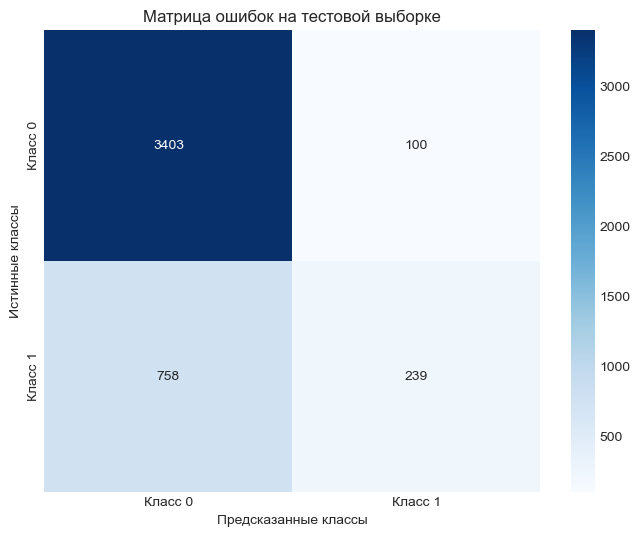

In [111]:
# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Класс 0', 'Класс 1'], 
            yticklabels=['Класс 0', 'Класс 1'])
plt.title('Матрица ошибок на тестовой выборке')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')
plt.show()

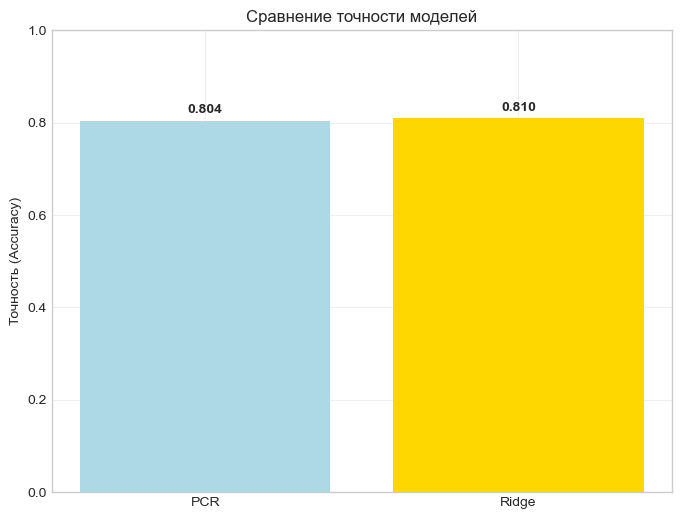

In [112]:
# Сравнение точности моделей
plt.figure(figsize=(8, 6))
colors = ['lightblue' if model != best_model_name else 'gold' for model in models_summary['Модель']]
bars = plt.bar(models_summary['Модель'], models_summary['Acc'], color=colors)
plt.ylim(0, 1)
plt.ylabel('Точность (Accuracy)')
plt.title('Сравнение точности моделей')
for i, v in enumerate(models_summary['Acc']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [113]:
print(f"Лучшая модель: {best_model_name}")

Лучшая модель: Ridge
